In [1]:
from pyspark.sql import SparkSession

nyc_taxi_challenge_path = '../../nyc-taxi-challenge/'

spark = SparkSession.builder.appName("NYC Taxi Challenge").getOrCreate()
spark

# Exploring the datasets

## Trips from 2009

This dataset has informations about taxi trips of 2009

In [20]:
#json_2009_trips = nyc_taxi_challenge_path + 'datasets/data-sample_data-nyctaxi-trips-2009-json_corrigido.json'
json_trips = nyc_taxi_challenge_path + 'datasets/data-sample_data-nyctaxi-trips-*'
trips_df = spark.read.json(json_trips)

trips_df.limit(100).toPandas()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,store_and_fwd_flag,surcharge,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id
0,2011-03-12T06:36:18.300191+00:00,40.747950,-73.994712,5.4,2,Cash,2011-03-12T06:28:30.352421+00:00,40.742950,-74.004114,None,None,0.0,0.00,0.00,5.40,0.80,CMT
1,2011-06-30T19:33:12.03231+00:00,40.792385,-73.940449,15.4,1,Cash,2011-06-30T19:25:12.618256+00:00,40.747784,-73.996506,None,None,0.0,0.00,0.00,15.40,5.40,CMT
2,2011-08-07T04:09:58.621034+00:00,40.768108,-73.944535,6.1,5,CASH,2011-08-07T04:03:02.398796+00:00,40.752070,-73.951340,None,None,1.0,0.00,0.00,7.10,1.67,VTS
3,2011-09-21T23:52:06.656228+00:00,40.721812,-73.958122,12.9,1,CASH,2011-09-21T23:37:38.878326+00:00,40.729128,-74.001117,None,None,0.5,0.00,0.00,13.40,4.13,VTS
4,2011-03-30T05:13:38.282117+00:00,40.776075,-73.979757,7.7,1,CASH,2011-03-30T05:03:23.020477+00:00,40.756873,-73.976600,None,None,0.5,0.00,0.00,8.20,2.03,VTS
5,2011-11-15T19:07:13.781446+00:00,40.750478,-73.978623,6.5,1,CASH,2011-11-15T18:57:56.343727+00:00,40.750528,-73.994665,None,None,0.0,0.00,0.00,6.50,1.15,VTS
6,2011-02-15T08:59:35.619783+00:00,40.774042,-73.870838,22.1,1,CASH,2011-02-15T08:50:12.238312+00:00,40.772843,-73.955462,None,None,0.0,0.00,4.15,26.25,8.61,VTS
7,2011-03-27T09:18:48.507995+00:00,40.759317,-73.985112,5.7,5,Credit,2011-03-27T09:05:54.607773+00:00,40.757998,-73.976158,None,None,0.0,2.00,0.00,7.70,0.84,VTS
8,2011-05-12T05:26:13.999779+00:00,40.761585,-73.975072,6.1,2,CASH,2011-05-12T05:17:11.215382+00:00,40.764408,-73.988585,None,None,0.0,0.00,0.00,6.10,1.04,VTS
9,2011-01-26T00:21:40.438829+00:00,40.747330,-73.993722,3.7,5,CASH,2011-01-26T00:07:03.801041+00:00,40.740683,-74.001978,None,None,0.0,0.00,0.00,3.70,0.75,VTS


## Payment lookup

This one is of payment lookup's:

In [3]:
from pyspark.sql.functions import col

csv_payment_lookup = nyc_taxi_challenge_path + 'datasets/data-payment_lookup-csv.csv'
payment_lookup_df = (
    spark.read
        .format('csv')
        .option('header', True)
        .load(csv_payment_lookup)
        .filter(col('A') != 'payment_type')
        .withColumnRenamed('A', 'payment_type')
        .withColumnRenamed('B', 'payment_lookup')
)

payment_lookup_df.limit(100).toPandas()

,payment_type,payment_lookup
0,Cas,Cash
1,CAS,Cash
2,Cre,Credit
3,CRE,Credit
4,No,No Charge
5,Dis,Dispute
6,Cash,Cash
7,CASH,Cash
8,Credit,Credit
9,CREDIT,Credit


## Vendor lookup

This is the vendor's lookup dataset:

In [4]:
from pyspark.sql.functions import col

csv_vendor_lookup = nyc_taxi_challenge_path + 'datasets/data-vendor_lookup-csv.csv'
vendor_lookup_df = (
    spark.read
        .format('csv')
        .option('header', True)
        .load(csv_vendor_lookup)
)

vendor_lookup_df.limit(100).toPandas()

,vendor_id,name,address,city,state,zip,country,contact,current
0,CMT,"Creative Mobile Technologies, LLC",950 4th Road Suite 78,Brooklyn,NY,11210,USA,contactCMT@gmail.com,Yes
1,VTS,VeriFone Inc,26 Summit St.,Flushing,NY,11354,USA,admin@vtstaxi.com,Yes
2,DDS,"Dependable Driver Service, Inc",8554 North Homestead St.,Bronx,NY,10472,USA,9778896500,Yes
3,TS,Total Solutions Co,Five Boroughs Taxi Co.,Brooklyn,NY,11229,USA,mgmt@5btc.com,Yes
4,MT,Mega Taxi,4 East Jennings St.,Brooklyn,NY,11228,USA,contact@megataxico.com,No


# Questions

Queremos que, a partir dos dados disponibilizados, você responda, de preferência com gráficos às seguintes questões:

1. Qual a distância média percorrida por viagens com no máximo 2 passageiros;
2. Quais os 3 maiores ​vendors​ em quantidade total de dinheiro arrecadado;
3. Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro;
4. Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.

## Distância média percorrida por viagens com no máximo 2 passageiros

In [21]:
from pyspark.sql.functions import (col, to_timestamp, to_date)
from pyspark.sql import Window

avg_distance = (
    trips_df.filter(col('passenger_count') <= 2)
        .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
        .withColumn('pickup_date', to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'))
        .select(
            col('pickup_date'), 
            col('trip_distance')
        )
        .groupBy('pickup_date')
        .avg()
)
avg_distance.limit(10).toPandas()

,pickup_date,avg(trip_distance)
0,2010-08-11,2.741329
1,2009-11-22,2.687557
2,2009-07-25,2.621888
3,2012-04-17,2.667261
4,2012-10-06,2.636528
5,2011-10-07,2.720898
6,2011-05-06,2.737548
7,2011-01-30,2.632873
8,2011-01-29,2.641509
9,2010-09-24,2.702701


## Os 3 maiores vendors em quantidade total de dinheiro arrecadado

In [34]:
from pyspark.sql.functions import (col)
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def pickup_semester(yearMonth):
    return str(yearMonth.year) + '-' + ('1' if yearMonth.month <= 6 else '2')

pickup_semester_udf = udf(pickup_semester, StringType())

revenue_per_vendor = (
    trips_df
            .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('pickup_semester', pickup_semester_udf(to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd')))
            .select(
                col('pickup_semester'),
                col('vendor_id'),
                col('total_amount')
            )
            .groupBy('vendor_id', 'pickup_semester')
            .sum()
)

revenue_per_vendor_pd = revenue_per_vendor.toPandas().sort_values(by=['pickup_semester', 'vendor_id'])
revenue_per_vendor_pd

,vendor_id,pickup_semester,sum(total_amount)
2,VTS,2009-1,2493499.53
10,DDS,2009-1,350491.43
9,CMT,2009-1,2554814.91
22,VTS,2009-2,2267358.97
12,DDS,2009-2,328234.00
5,TS,2009-2,11.40
11,CMT,2009-2,2332456.16
0,CMT,2010-1,2547867.35
25,TS,2010-1,11.40
27,DDS,2010-1,352894.92


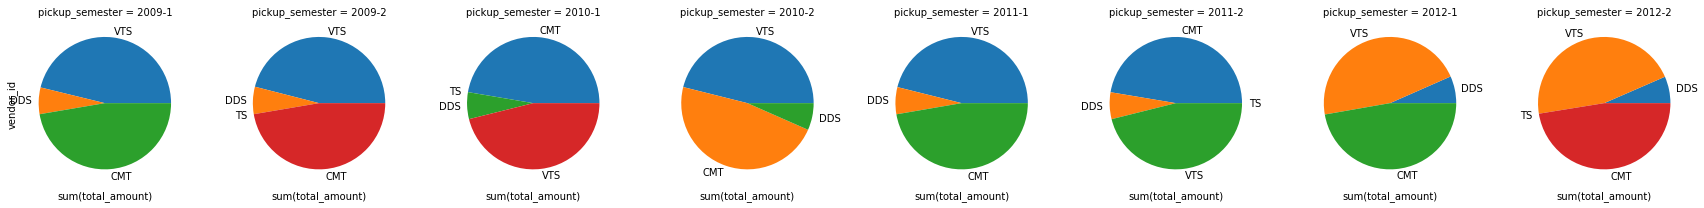

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# values = revenue_per_vendor_pd['sum(total_amount)']
# labels = revenue_per_vendor_pd['vendor_id']
# semesters = revenue_per_vendor_pd['pickup_semester']

def pie(v, l, color=None):
    plt.pie(v, labels=l.values)
g = sns.FacetGrid(revenue_per_vendor_pd, col="pickup_semester")
g.map(pie, "sum(total_amount)", "vendor_id" )

plt.show()

## Histograma da distribuição mensal (nos 4 anos) de corridas pagas em dinheiro

In [40]:
from pyspark.sql.functions import (col, lower, date_format)

monthly_cash_revenues = (
    trips_df
            .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('pickup_month', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM'), 'yyyy-MM'))
            .withColumn('payment_type', lower(col('payment_type')))
            .filter(col('payment_type') == 'cash')
            .select(
                col('pickup_month'),
                col('total_amount')
            )
)

gre_histogram = (
    monthly_cash_revenues
        .filter(col('pickup_month') == '2010-1')
        .select('total_amount')
        .rdd.flatMap(lambda x: x).histogram(11)
)

pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

ValueError: Can not reduce() empty RDD

## Quantidade de gorjetas por dia nos últimos 3 meses de 2012

# Bonus questions


- Qual o tempo médio das corridas nos dias de sábado e domingo;
- Fazer uma visualização em mapa com latitude e longitude de ​pickups and ​dropoffs ​no ano de 2010;
- Simular um ​streaming dos dados dos ​JSON e fazer uma visualização acompanhando uma métrica em tempo-real;
- Conseguir provisionar todo seu ambiente em uma cloud pública, de preferência ​AWS​.

## Tempo médio das corridas nos dias de sábado e domingo

## Visualização em mapa com latitude e longitude de pickups e dropoffs no ano de 2010